# Evaluating trained models

## Load Test Dataset + Model

In [1]:
import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import os

from glob import glob

import IPython.display as ipd
device = torch.device('cuda:0')

In [2]:
from model.ConvTasNet import ConvTasNet
from create_dataset import Datasets
from utils import infer_song

In [3]:
test_data_kwargs = {
    'mix_path': '../musdb18_8000/train/ins',
    'src_path': ['../musdb18_8000/train/bass','../musdb18_8000/train/drums', '../musdb18_8000/train/other'],
    'sr': 8000,
    'chunk_size': 32000
}

loader_kwargs = {
    'batch_size': 1,
    'num_workers': 4,
    'shuffle': True,
    'drop_last': True
}

test_dataset = Datasets(**test_data_kwargs)

test_dataloader = DataLoader(test_dataset, **loader_kwargs)


loaded 120 mix
loaded sources:
	- 120
	- 120
	- 120


In [4]:
tcn_kwargs = {
    'n_blocks': 8,
    'n_repeats': 4,
    'bn_chan': 128,
    'norm_type': 'fgLN',
    'mask_act': 'prelu'
}


In [5]:

network_kwargs = {
    'in_channels': 1,
    'out_channels': 1,
    'masks_num': 3,
    'filters_num': 512,
    'filters_len': 16,
    'tdcnpp': True,
    'enc_layer_num': 3, 
    'dec_layer_num': 3,
}

model_path = '../runs/011_mse_enc/950.pt'

model = ConvTasNet(**network_kwargs, **tcn_kwargs)
cpt = torch.load(model_path, map_location='cpu')
model.load_state_dict(cpt['model_state_dict'])

model = model.to(device)

## Inference

### Original

In [6]:
track_name = '013_good_time'
source_name = ['ins','bass','drums','other']

for s in source_name:
    test_x, sr = torchaudio.load(f'../musdb18_8000/test/{s}/{track_name}_{s}.wav')
    test_x = test_x[:,1005000:1293000]
    print(s)
    ipd.display(ipd.Audio(test_x, rate=sr))


ins


bass


drums


other


### Infered

In [7]:
test_x, sr = torchaudio.load(f'../musdb18_8000/test/ins/{track_name}_ins.wav')
test_x = test_x[:,1005000:1293000]
outs = infer_song(model,test_x,device,batch_size=2)
for i,out in enumerate(outs):
    print(source_name[i+1])
    ipd.display(ipd.Audio(out, rate=sr))

bass


drums


other


## SI-SDR

In [7]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio,SignalDistortionRatio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sdr = SignalDistortionRatio().to(device)


In [171]:

source_name = ['ins','bass','drums','other']
epoch = 3

In [172]:
model_paths = ['../runs/013_mse_enc/950.pt','../runs/011_mse_enc/950.pt','../runs/012_mse_enc/950.pt']

model_configs = [{
                    'in_channels': 1,
                    'out_channels': 1,
                    'masks_num': 3,
                    'filters_num': 512,
                    'filters_len': 16,
                    'tdcnpp': True,
                    'enc_layer_num': 2, 
                    'dec_layer_num': 2,
                },{
                    'in_channels': 1,
                    'out_channels': 1,
                    'masks_num': 3,
                    'filters_num': 512,
                    'filters_len': 16,
                    'tdcnpp': True,
                    'enc_layer_num': 3, 
                    'dec_layer_num': 3,
                },{
                    'in_channels': 1,
                    'out_channels': 1,
                    'masks_num': 3,
                    'filters_num': 512,
                    'filters_len': 16,
                    'tdcnpp': True,
                    'enc_layer_num': 4, 
                    'dec_layer_num': 4,
                }]

In [173]:
boxes = []
for m, model_path in enumerate(model_paths):
    
    model = ConvTasNet(**model_configs[m], **tcn_kwargs)
    print(f'loaded model with encoding layer {model_configs[m]["enc_layer_num"]}')
    
    cpt = torch.load(model_path, map_location='cpu')
    model.load_state_dict(cpt['model_state_dict'])
    
    model = model.to(device)
        
    box = [[] for _ in range(len(source_name)-1)]
    for e in range(epoch):
        scores = []
        with torch.no_grad():
            count = 0
            for test in test_dataloader:
                outs = model(test['mix'].to(device))
                try:
                    score = [sdr(outs[i][:,0,:], test['src'][i][:,0,:].to(device)) for i in range(len(outs))]
                    scores.append(torch.stack(score))
                except:
                    count = count + 1
        scores = torch.stack(scores)
        scores = torch.mean(scores, dim=0)
        print(f'epoch {e} SDR: {source_name[1]}: {scores[0]:.5f}, {source_name[2]}: {scores[1]:.5f}, {source_name[3]}: {scores[2]:.5f}\t{count} empty')
        box[0].append(scores[0].item())
        box[1].append(scores[1].item())
        box[2].append(scores[2].item())
    boxes.append(box)

loaded model with encoding layer 2
bass: 3.69940, drums: 4.51547, other: 6.09758
8 empty
bass: 4.46899, drums: 4.66766, other: 6.88808
13 empty
bass: 4.75422, drums: 4.89560, other: 6.00437
9 empty
loaded model with encoding layer 3
bass: 4.84234, drums: 4.83051, other: 5.49080
8 empty
bass: 5.35981, drums: 4.90236, other: 6.28752
11 empty
bass: 5.15776, drums: 5.28312, other: 6.01795
9 empty
loaded model with encoding layer 4
bass: 4.48750, drums: 4.67274, other: 6.21960
9 empty
bass: 5.76207, drums: 5.23159, other: 5.39259
11 empty
bass: 5.23231, drums: 5.11848, other: 5.59785
12 empty


In [183]:


def draw_boxplot(boxes, labels, sub_plot_name, column_names=['Instrument', 'SDR']):
    all_df = [pd.DataFrame({'index': np.arange(len(box[0])), 'Bass': box[0], 'Drums': box[1], 'Other': box[2]}) for box in boxes]

    fig, axs = plt.subplots(1, 3, figsize=(5, 3), sharey=True)
    ax = [0,1,2]
    
    for i, df in enumerate(all_df):
        df_long = pd.melt(df, id_vars = ['index'], value_vars=labels)
        df_long.columns = ['index', *column_names]
        
        if i == 0:
            ax[i] = sns.boxplot(data=df_long, x='Instrument', y="SDR", hue=df_long.Instrument.tolist(), ax = axs[i], legend='full')
            ax[i].set_xticks(ax[i].get_xticks(),labels=['','',''])
            ax[i].set(xlabel=' ')
            ax[i].set_title(sub_plot_name[i], fontsize=10)
            axs[i].legend([],[], frameon=False)
            axs[i].grid()
            
        else:
            ax[i] = sns.boxplot(data=df_long, x='Instrument', y="SDR", hue=df_long.Instrument.tolist(), ax = axs[i], legend=False)
            ax[i].set_xticks(ax[i].get_xticks(),labels=['','',''])
            ax[i].set(xlabel=' ')
            ax[i].set_title(sub_plot_name[i], fontsize=10)
            axs[i].legend([],[], frameon=False)
            axs[i].grid()
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.92, 0.88), loc='upper left',borderaxespad=0)
    
    plt.show()
  

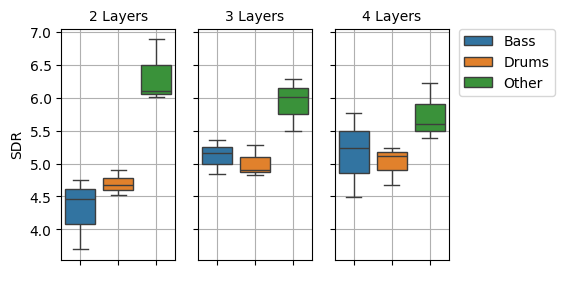

In [185]:
sub_plot_name = [f'{model_config["enc_layer_num"]} Layers' for model_config in model_configs]
draw_boxplot(boxes, labels, sub_plot_name)

## Visualise the Mask

In [6]:
track_name = '013_good_time'

test_x, sr = torchaudio.load(f'../musdb18_8000/test/ins/{track_name}_ins.wav')
# test_x = test_x[:,1005000:1293000]
test_x = test_x[:,1005000+2*32000:1005000+32000*3]

In [79]:
ipd.display(ipd.Audio(test_x, rate=8000))

In [7]:
def infer_mask_from_song(model, x, device, batch_size = 4, chunk_size=32000):
    
    assert x.dim() == 2, "[Channel, T]"
    assert x.shape[1]>=chunk_size
    
    chunk_num = (x.shape[1] - x.shape[1]%chunk_size)//chunk_size
    chunks = x[:,:x.shape[1]-x.shape[1]%chunk_size].chunk(chunk_num,dim=1) 
    chunks_torch = torch.stack(chunks)
    chunks = chunks_torch.split(batch_size)
    # print([chunk.shape for chunk in chunks])
    
    sources = [[] for i in range(model.source_num)]
    masks = []
    model = model.to(device)
    with torch.no_grad():
        
        for chunk in chunks:
            out, m = model(chunk.to(device), return_mask = True)
            masks.append(m.view(model.source_num, model.filters_num, -1))
        masks_all = torch.cat(masks,dim=2)
    
    return masks_all

In [8]:

outs = infer_song(model,test_x,device,batch_size=2)
ipd.display(ipd.Audio(outs[2], rate=8000))

In [9]:
m = infer_mask_from_song(model,test_x,device = device,batch_size=2)

In [17]:
from torch.nn.functional import normalize
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def euclidean_distance(x1, x2):
    assert x1.dim()==1
    return torch.cdist(x1.unsqueeze(0), x2.unsqueeze(0), p=2.0)

def sort_filters(mask, start_idx = 0):
    
    assert mask.dim() == 2
    n = mask.shape[0]
    distances = np.zeros((n, n))
    
    masks = list(mask.unbind(0))
    
    filters = []
    filters.append(masks[start_idx])
    
    # mask: [filters_num, t]
    last_idx = masks[start_idx]
    masks.pop(start_idx)
    for i in range(1,n):
        distances = []
        for j in range(len(masks)):
            distances.append(euclidean_distance(last_idx,masks[j]))
        distances_t = torch.stack(distances)
        _, sorted_indices = torch.sort(distances_t[:,0,0])
        
        idx = sorted_indices[0]
        filters.append(masks[idx])
        last_idx = masks[idx]
        masks.pop(idx)
    
    return torch.stack(filters)

def filter_normalise(mask):
    assert mask.dim() == 2
    filters = mask.unbind(0)
    norm_filters = []
    for f in filters:
        d = f.max() - f.min()
        norm_filters.append(f.add(-f.min())/d)
    return torch.stack(norm_filters)
    

In [13]:
normed_mask = filter_normalise(m[0][:,1:-1])

In [18]:
sorted_mask = sort_filters(normed_mask, start_idx = 4)

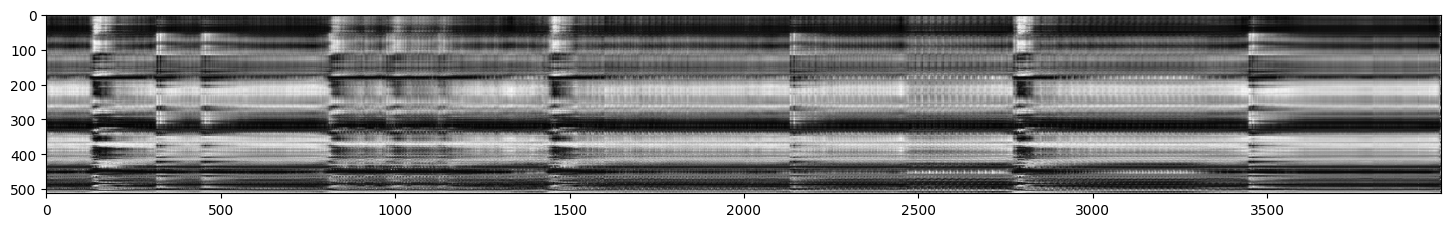

In [140]:
plt.figure(figsize=(18,6))
plt.imshow(sorted_mask[:,:].cpu().detach().numpy(),cmap='gray')

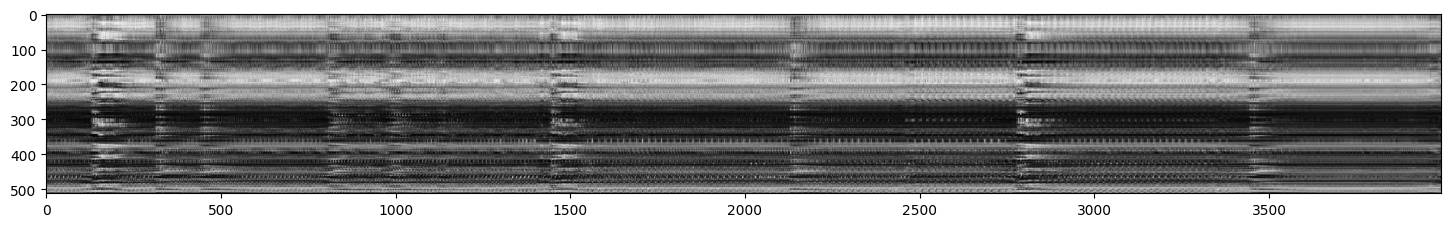

In [27]:
plt.figure(figsize=(18,6))
plt.imshow(sorted_mask[:,:].cpu().detach().numpy(),cmap='gray')

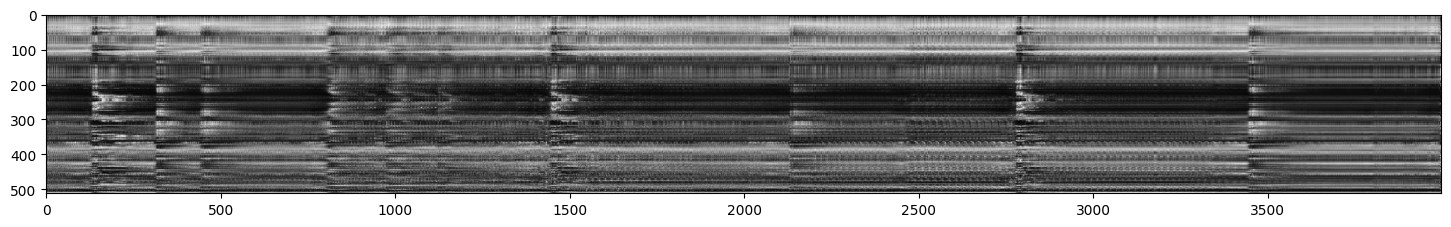

In [15]:
plt.figure(figsize=(18,6))
plt.imshow(sorted_mask[:,:].cpu().detach().numpy(),cmap='gray')